# Persiapan Library

In [1]:
# ====== Standard Library ======
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
import nltk
import matplotlib.pyplot as plt

# ====== Scikit-learn ======
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

# ====== NLTK =======
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# ====== WordCloud =======
from wordcloud import WordCloud

# ====== HuggingFace Transformers ======
from transformers import DistilBertTokenizer, TFDistilBertModel

# ====== spearmanr =======
from scipy.stats import spearmanr

# ====== Keras - Callbacks & Utilities ======
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# ====== Keras - Model Building (Functional & Sequential APIs) ======
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Embedding, LSTM, GRU, Bidirectional, Conv1D,
    GlobalMaxPooling1D
)

# ====== Keras - Preprocessing ======
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ====== Sklearn =====
from sklearn.metrics import accuracy_score

/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('words') 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ivanbesti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/ivanbesti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanbesti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ivanbesti/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanbesti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/ivanbesti/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

# Tahap 1: Persiapan Dataset

## 1.1. Kumpulkan dan Pahami Dataset

In [3]:
# Load dataset
df = pd.read_csv("pubg_reviews.csv")

# Periksa 5 baris pertama untuk memahami struktur dataset
df.head()

,userName,score,content,at
0,Andreas Djsubekti,5,amazing,2025-03-25 20:51:06
1,noufal ossama,1,لاق وتقطيع بدات الي 60 فريم,2025-03-25 20:49:24
2,Saifullah memon,5,best game ever,2025-03-25 20:44:32
3,Isaac Okyere,5,Is very interesting game to Play.,2025-03-25 20:43:04
4,panpan panpan,5,Okay ပါ,2025-03-25 20:42:37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  10000 non-null  object
 1   score     10000 non-null  int64 
 2   content   10000 non-null  object
 3   at        10000 non-null  object
dtypes: int64(1), object(3)
memory usage: 312.6+ KB


In [5]:
df.shape

(10000, 4)

## Data Explanation: PUBG Reviews Dataset

Dataset ini berisi **10.000 ulasan pengguna** terhadap game PUBG di platform Playstore. Tujuan utama dari dataset ini adalah untuk menganalisis sentimen pengguna terhadap game berdasarkan ulasan teks (*content*) dan skor (*score*) yang diberikan.

### Struktur Dataset

| Kolom         | Tipe Data | Deskripsi                                                                 |
|---------------|-----------|---------------------------------------------------------------------------|
| `userName`    | object    | Nama pengguna yang memberikan ulasan                                      |
| `score`       | int64     | Skor rating yang diberikan oleh pengguna terhadap game (rentang 1–5)      |
| `content`     | object    | Isi ulasan (bisa berupa teks dalam Bahasa Inggris, Arab, dll.)            |
| `at`          | object    | Timestamp kapan ulasan tersebut diberikan                                 |

### Informasi Tambahan
- Total data: **10.000 baris** (tanpa missing values)
- Total kolom: **4 kolom**
- Ukuran memori: **312.6 KB**
- Tipe ulasan: Multibahasa (termasuk Bahasa Inggris dan Bahasa Arab)
- Rentang nilai `score`: 1 (terburuk) hingga 5 (terbaik)

### Catatan:
- Kolom `content` akan menjadi fokus utama untuk analisis sentimen.
- Kolom `score` bisa digunakan sebagai label sentimen (misalnya: 1–2 = *Negative*, 3 = *Neutral*, 4–5 = *Positive*).
- Sebaiknya dilakukan pra-pemrosesan (cleaning) terhadap teks pada kolom `content` untuk menghilangkan noise seperti emoji, HTML tags, dan teks multibahasa jika diperlukan.

---

## 1.2. Preprocessing & Cleaning Data

In [6]:
def visualize_missing_values(df):
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    
    # Filter only columns with missing values
    missing_df = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
    
    if missing_df.empty:
        print("No missing values in the dataset.")
        return
    
    # Plot bar chart
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_df.index, y=missing_df.values, palette="viridis")
    plt.xticks(rotation=45)
    plt.ylabel("Percentage of Missing Values")
    plt.title("Missing Values Percentage per Column")
    plt.show()

# Example usage
visualize_missing_values(df)

No missing values in the dataset.


In [7]:
df['at'] = pd.to_datetime(df['at']).dt.date

In [8]:
df.head()

,userName,score,content,at
0,Andreas Djsubekti,5,amazing,2025-03-25
1,noufal ossama,1,لاق وتقطيع بدات الي 60 فريم,2025-03-25
2,Saifullah memon,5,best game ever,2025-03-25
3,Isaac Okyere,5,Is very interesting game to Play.,2025-03-25
4,panpan panpan,5,Okay ပါ,2025-03-25


<Figure size 1200x600 with 0 Axes>

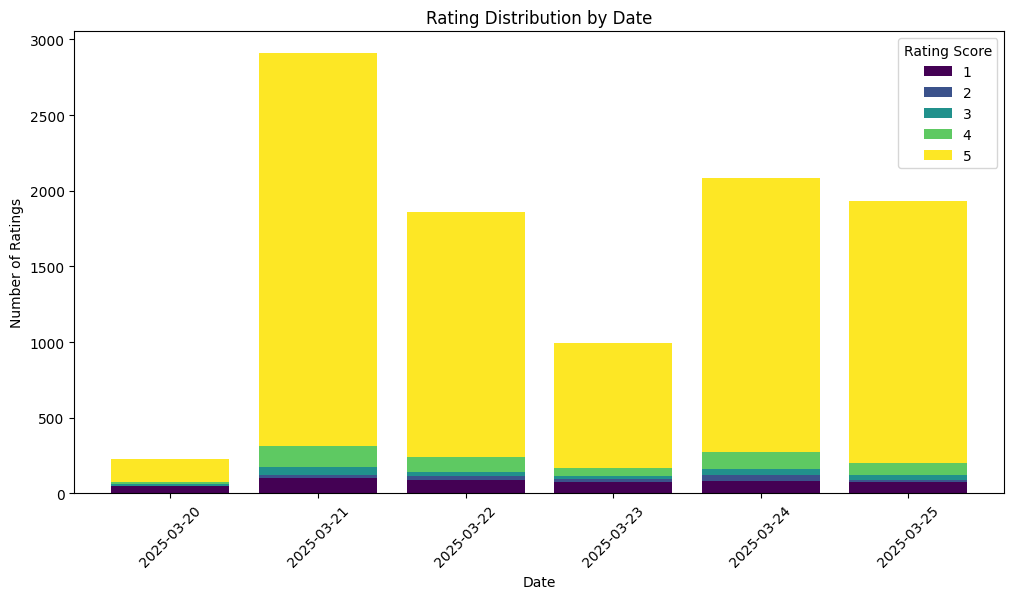

In [9]:
# Group by date and count occurrences of each rating score
rating_distribution = df.groupby(['at', 'score']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
rating_distribution.plot(kind='bar', stacked=True, colormap='viridis', width=0.8, figsize=(12, 6))

plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.title("Rating Distribution by Date")
plt.xticks(rotation=45)
plt.legend(title="Rating Score")
plt.show()

### Insight: Distribusi Rating PUBG per Tanggal

Grafik di atas menunjukkan distribusi jumlah rating yang diberikan pengguna PUBG pada rentang tanggal **2025-03-20 hingga 2025-03-25**. Terlihat bahwa sebagian besar ulasan diberikan pada **2025-03-21**, dengan lebih dari 2.900 review tercatat pada hari tersebut. Mayoritas pengguna memberikan rating **5 (sangat puas)**, yang ditunjukkan oleh dominasi warna kuning pada semua tanggal.

Pola ini mengindikasikan bahwa meskipun ada beberapa ulasan negatif (rating 1–2), sentimen pengguna secara umum cenderung **positif** selama periode ini. Lonjakan aktivitas pada 2025-03-21 kemungkinan berkaitan dengan event, update, atau promosi tertentu dalam game yang memicu keterlibatan pengguna lebih tinggi.

In [10]:
def check_and_remove_duplicates(df):
    # Normalize userName (optional but recommended)
    df['userName'] = df['userName'].str.lower().str.strip()
    
    # Count users with multiple reviews
    user_review_counts = df['userName'].value_counts()
    users_with_multiple_reviews = user_review_counts[user_review_counts > 1].index
    
    print(f"Total users with more than one review: {len(users_with_multiple_reviews)}")
    
    # Show sample of users with multiple reviews before removal
    if len(users_with_multiple_reviews) > 0:
        print("\nSample of users with multiple reviews before removal:")
        display(df[df['userName'].isin(users_with_multiple_reviews)].head())

    # Store original shape
    before_shape = df.shape

    # Sort by latest review date and keep only the latest review per user (if they have multiple)
    df = df.sort_values(by='at', ascending=False)  
    df = df[~df['userName'].duplicated(keep='first')] 

    # Store new shape
    after_shape = df.shape

    # Report results
    print(f"\nBefore removing duplicates: {before_shape[0]} rows")
    print(f"After removing duplicates: {after_shape[0]} rows")
    print(f"Total removed: {before_shape[0] - after_shape[0]} rows")

    return df 

# Example usage
df = check_and_remove_duplicates(df)

Total users with more than one review: 268

Sample of users with multiple reviews before removal:


,userName,score,content,at
44,faizan khan,5,very good game,2025-03-25
54,jamil khan,5,This game is very good but it has too many fun...,2025-03-25
74,faizan khan,4,Pubg bahut acchi hai na magar low device main ...,2025-03-25
91,muhammad qasim,5,amazing game,2025-03-25
93,qasim khan,5,I like the game,2025-03-25



Before removing duplicates: 10000 rows
After removing duplicates: 9536 rows
Total removed: 464 rows


In [11]:
df.shape

(9536, 4)

In [12]:
df.content.duplicated().sum()
df.userName.duplicated().sum()

np.int64(0)

In [13]:
english_words = set(words.words())

def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions (@username)
        text = re.sub(r'#\w+', '', text)  # Remove hashtags
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters (including emojis)
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

def is_english(text):
    if not isinstance(text, str) or not text.strip():
        return False  
    
    words_in_text = text.split()
    if not words_in_text:
        return False  
    
    english_count = sum(1 for word in words_in_text if word in english_words)
    return english_count / len(words_in_text) >= 0.6 
    
# Apply cleaning function
df['content_cleaned'] = df['content'].apply(clean_text)

# Filter for only English rows
df = df[df['content_cleaned'].apply(is_english)]

# Drop empty rows (if any)
df = df[df['content_cleaned'].str.strip() != '']

In [14]:
# Show sample after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
2355,good 👍🏻,good
2835,I like it very much it will makes me feel awes...,i like it very much it will makes me feel awes...
4894,am really happy to have this game. i see it as...,am really happy to have this game i see it as ...
9884,it's good or incredible but it goes off when a...,its good or incredible but it goes off when am...
9426,Pubg Mobile Is Amazing 😉 Game In World 🌎,pubg mobile is amazing game in world
738,very gode,very gode
5247,enjoying,enjoying
2265,beautiful game!,beautiful game
9781,I love it I love playing PUBG it's fun and nice,i love it i love playing pubg its fun and nice
3667,i like pupg god,i like pupg god


In [15]:
# Define a dictionary of slang words and their formal replacements
slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "wanna": "want to",
    "gonna": "going to",
    "gotta": "got to",
    "lemme": "let me",
    "gimme": "give me",
    "aint": "is not",
    "im": "I am",
    "iam": "I am",
    "idk": "I don't know",
    "btw": "by the way",
    "lol": "laughing out loud",
    "brb": "be right back",
    "omg": "oh my god",
    "thx": "thanks",
    "ty": "thank you",
    "lmk": "let me know",
    "smh": "shaking my head",
    "fyi": "for your information",
    "tbh": "to be honest",
    "dm": "direct message",
    "dis": "this",
    "plz": "please",
    "gam": "game"
}

# Compile regex pattern for fast lookup
slang_pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in slang_dict.keys()) + r')\b', re.IGNORECASE)

def replace_slang(text):
    if isinstance(text, str):
        return slang_pattern.sub(lambda match: slang_dict[match.group(0).lower()], text)
    return text

# Apply slang replacement to 'content_processed' column
df['content_cleaned'] = df['content_cleaned'].apply(replace_slang)

In [16]:
# Show some samples after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
9478,good game but i need m4 glacier plz help me,good game but i need m glacier please help me
1631,best game ever,best game ever
8493,Awesome,awesome
4700,I Like It This Game ❤,i like it this game
1754,"i like everything like colors, mythic and cars...",i like everything like colors mythic and cars ...
2641,I have played this game six years and I am sti...,i have played this game six years and i am sti...
9326,fantastic 🤲,fantastic
2810,wow amazing game,wow amazing game
6392,Sir Sir please i want to grow my pubg account ...,sir sir please i want to grow my pubg account ...
2632,nice game in the world,nice game in the world


In [17]:
# Load NLTK stopwords
nltk_stopwords = set(stopwords.words('english'))

# Expand stopwords with domain-specific terms
custom_stopwords = {
    "game", "pubg", "mobile", "play", "player", "gaming", "like",
    "cant", "dont", "doesnt"
}

# Merge both stopword sets
stop_words = frozenset(nltk_stopwords | custom_stopwords)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Regex to filter out non-alphabetic words (ignores numbers, symbols, etc.)
alpha_pattern = re.compile(r"^[a-zA-Z]+$")  

def preprocess_text(text):
    if not isinstance(text, str) or not text.strip():
        return None  # Return None for non-string or empty inputs

    # Tokenization & Lowercasing
    tokens = word_tokenize(text.lower())

    # Stopword removal & Lemmatization (keeping only alphabetic words)
    processed_tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and alpha_pattern.match(word)
    ]

    return " ".join(processed_tokens) if processed_tokens else None 
    
# Apply preprocessing safely
if 'content_cleaned' in df.columns:
    df['content_cleaned'] = df['content_cleaned'].astype(str).apply(preprocess_text)
    df.dropna(subset=['content_cleaned'], inplace=True) 
else:
    print("Column 'content_cleaned' not found in DataFrame")

In [18]:
# Show sample after processing
df[['content', 'content_cleaned']].sample(10)

,content,content_cleaned
9898,Pubg is getting worse download every day hell ...,getting worse download every day hell make run mb
5691,Since 2023 I payed this game.Nice game I have ...,since payed gamenice far
904,nice PUBG mobile,nice
3429,best time spending things in my life. And I am...,best time spending thing life pro
420,all time my favorite,time favorite
369,Best mobile game in the world,best world
6100,its good,good
7945,best shooting game ever.🫰,best shooting ever
6440,best,best
481,easy 😉,easy


In [19]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if isinstance(text, str):
        score = sia.polarity_scores(text)['compound']
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"
    return "Neutral"

# Apply sentiment analysis to the 'content_lemmatized' column
df['sentiment'] = df['content_cleaned'].apply(get_sentiment)

In [20]:
# Show sample results
df[['content_cleaned', 'sentiment']].sample(10)

,content_cleaned,sentiment
7274,good,Positive
7156,good really enjoy free time support u defeat p...,Positive
5533,best gameit interesting,Positive
1618,nice big fan,Positive
4774,thank giving great experience,Positive
2275,jamming actually despite various alias awsome ...,Positive
7068,nice,Positive
8501,love much,Positive
5764,best,Positive
888,hi quality,Neutral


# 2. Exploratory Data Analysis

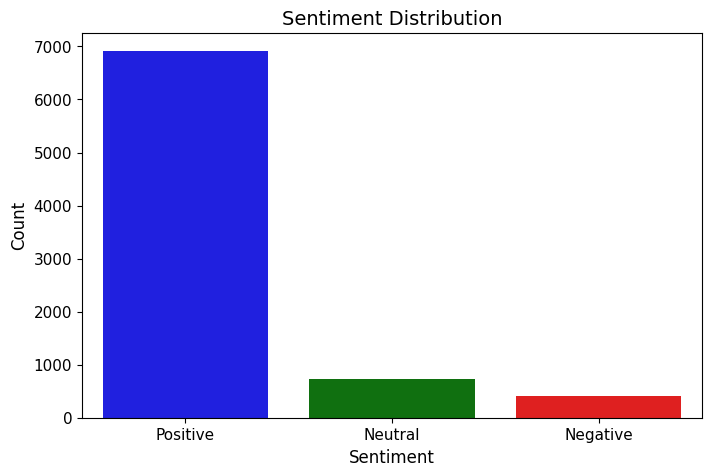

In [21]:
# Count sentiment distribution
sentiment_counts = df['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, hue=sentiment_counts.index, palette=['blue', 'green', 'red'], legend=False)

# Customize labels
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Sentiment Distribution", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Show the plot
plt.show()

## Insight dari Distribusi Sentimen  

Mayoritas ulasan PUBG memiliki sentimen positif, menunjukkan bahwa sebagian besar pemain puas dengan pengalaman mereka. Sejumlah kecil ulasan bersifat netral, yang mungkin berasal dari pemain yang tidak memiliki opini kuat. Sementara itu, ulasan negatif relatif sedikit, menandakan bahwa keluhan atau ketidakpuasan bukanlah hal yang dominan dalam dataset ini.  

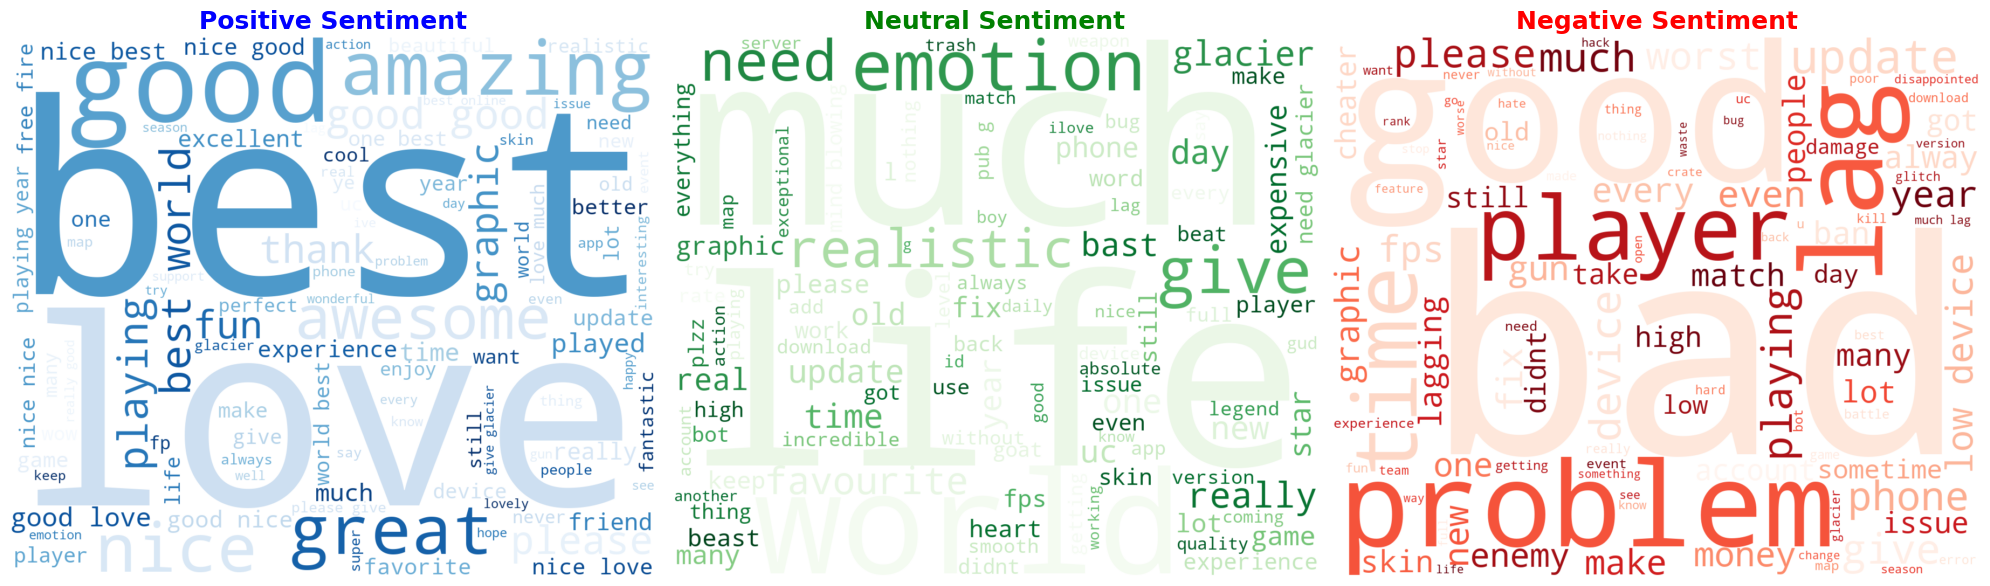

In [22]:
# Define color maps for each sentiment
colormaps = {
    'Positive': 'Blues',
    'Neutral': 'Greens',
    'Negative': 'Reds'
}

# Create a subplot with optimized spacing
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, sentiment in enumerate(['Positive', 'Neutral', 'Negative']):
    text = " ".join(df[df['sentiment'] == sentiment]['content_cleaned'].dropna())
    
    # Generate word cloud with refined parameters
    wordcloud = WordCloud(
        width=1200, height=1000, 
        background_color='white', 
        colormap=colormaps[sentiment],
        max_words=100,
        contour_color='black',
        contour_width=2,
        random_state=42 
    ).generate(text)

    # Display word cloud
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis("off")
    axes[idx].set_title(f"{sentiment} Sentiment", fontsize=18, fontweight='bold', color=colormaps[sentiment].split('s')[0])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Insight: WordCloud Berdasarkan Kategori Sentimen

Visualisasi di atas memperlihatkan **kata-kata yang paling sering muncul** dalam ulasan pengguna PUBG, dikelompokkan berdasarkan kategori sentimen:

- **Positive Sentiment:**  
  Kata-kata seperti **"best"**, **"love"**, **"great"**, **"amazing"**, dan **"awesome"** mendominasi wordcloud positif. Hal ini menunjukkan bahwa pengguna yang merasa puas cenderung mengekspresikan pengalaman mereka dengan kata-kata pujian dan apresiasi terhadap gameplay, grafik, dan fitur game.

- **Neutral Sentiment:**  
  Kata seperti **"realistic"**, **"emotion"**, **"need"**, dan **"give"** muncul cukup dominan. Ulasan netral cenderung berisi permintaan atau opini teknis tanpa emosi kuat. Ini menunjukkan adanya harapan atau saran dari pemain tanpa kecenderungan sangat suka atau sangat tidak suka.

- **Negative Sentiment:**  
  Kata-kata seperti **"problem"**, **"player"**, **"lagging"**, **"damage"**, dan **"please"** menjadi pusat dalam wordcloud negatif. Ini mengindikasikan bahwa keluhan utama pemain mencakup masalah teknis seperti lag, performa buruk, dan frustrasi terhadap gameplay atau update terbaru.

<Figure size 1000x600 with 0 Axes>

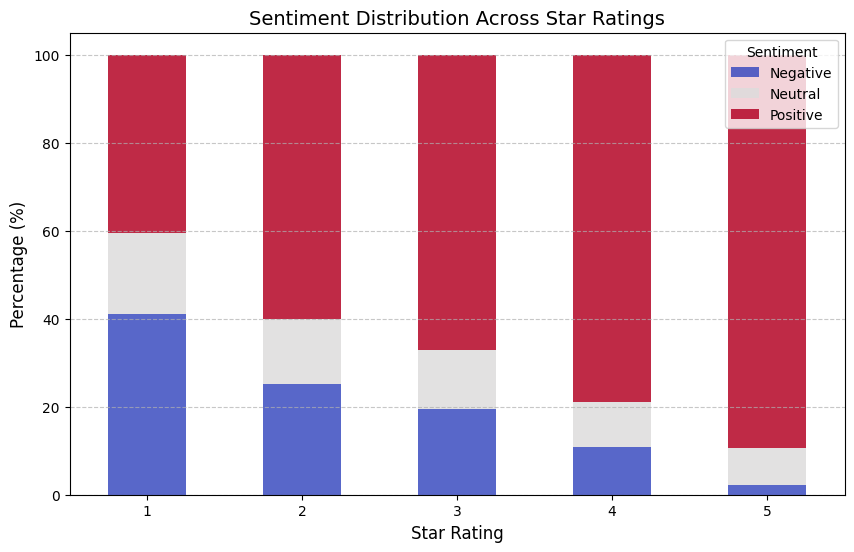

Spearman Correlation between Rating and Sentiment Score: 0.2905
P-value: 0.0000


In [23]:
# Count sentiment distribution for each rating
sentiment_rating_dist = df.groupby(["score", "sentiment"]).size().unstack(fill_value=0)

# Normalize (convert to percentage)
sentiment_rating_dist = sentiment_rating_dist.div(sentiment_rating_dist.sum(axis=1), axis=0) * 100

# Plot Sentiment Distribution Across Ratings
plt.figure(figsize=(10, 6))
sentiment_rating_dist.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.85, figsize=(10, 6))

plt.title("Sentiment Distribution Across Star Ratings", fontsize=14)
plt.xlabel("Star Rating", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Correlation Analysis (Spearman correlation)
# Convert sentiment to numerical values for correlation (Negative=-1, Neutral=0, Positive=1)
sentiment_mapping = {"Negative": -1, "Neutral": 0, "Positive": 1}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

# Calculate Spearman correlation between rating and sentiment score
correlation, p_value = spearmanr(df["score"], df["sentiment_score"])

print(f"Spearman Correlation between Rating and Sentiment Score: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

## Insight dari Distribusi Sentimen Berdasarkan Rating  

- **Hubungan antara Rating dan Sentimen**: Grafik menunjukkan bahwa ulasan dengan **rating lebih tinggi (4-5 bintang)** didominasi oleh sentimen **positif** (merah), sementara ulasan dengan **rating lebih rendah (1-2 bintang)** cenderung memiliki lebih banyak **sentimen negatif** (biru).  
- **Netralitas pada Rating Tengah**: Ulasan dengan **3 bintang** memiliki distribusi yang lebih seimbang antara sentimen positif, netral, dan negatif, menunjukkan bahwa pemain memiliki pengalaman campuran.  
- **Korelasi**: Dengan nilai **Spearman Correlation sebesar 0.2905**, terdapat hubungan positif antara rating dan sentimen, meskipun tidak terlalu kuat.  

Secara keseluruhan, semakin tinggi rating, semakin positif sentimen pemain terhadap game ini.  

# 3. Modelling

## 3.1 Bidirectional LSTM (BiLSTM)

In [110]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label Encoding
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment']) 

# Tokenization
max_words = 10000 
max_len = 100     

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])

X = tokenizer.texts_to_sequences(df['content_cleaned'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment']) 

# Stratified Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

def create_optimized_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Dropout(0.4), 
        Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        Bidirectional(LSTM(32, return_sequences=False, dropout=0.3, recurrent_dropout=0.2)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)), 
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Create new model
model = create_optimized_lstm_model(vocab_size=max_words, embedding_dim=100, input_length=max_len)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.8086 - loss: 1.0932 - val_accuracy: 0.8585 - val_loss: 0.7654 - learning_rate: 5.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 220ms/step - accuracy: 0.8615 - loss: 0.7587 - val_accuracy: 0.8585 - val_loss: 0.6069 - learning_rate: 5.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.8722 - loss: 0.5379 - val_accuracy: 0.9106 - val_loss: 0.3855 - learning_rate: 5.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - accuracy: 0.9177 - loss: 0.3786 - val_accuracy: 0.9212 - val_loss: 0.3231 - learning_rate: 5.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 230ms/step - accuracy: 0.9250 - loss: 0.3012 - val_accuracy: 0.9174 - val_loss: 0.3033 - learning_rate: 5.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - accuracy: 0.9397 - loss: 0.2359 - val_accuracy: 0.9205 - val_loss: 0.2646 - learning_rate: 5.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 23s 22

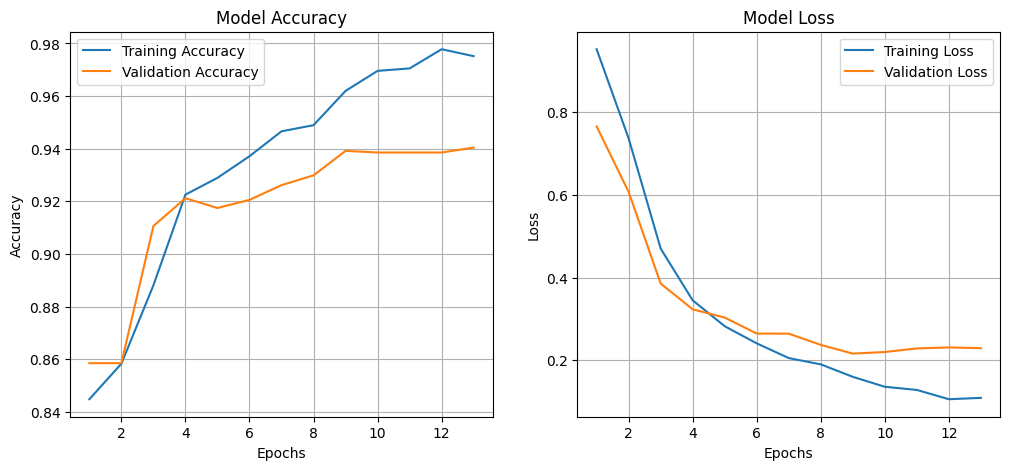

In [111]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Insight: Kinerja Model Selama Pelatihan

Grafik di atas menampilkan **akurasi** dan **loss** dari model **BiLSTM** selama pelatihan, baik pada data training maupun data validasi.

---

#### Model Accuracy (Kiri)
- Akurasi pada data **training** meningkat signifikan dari sekitar **85%** hingga mencapai **99%** di akhir epoch.
- Akurasi pada data **validasi** juga meningkat stabil hingga **95–96%**, namun mulai melambat setelah epoch ke-4.
- Terdapat **gap yang makin besar** antara training dan validation accuracy setelah epoch ke-5, yang menandakan gejala **overfitting**.

---

#### Model Loss (Kanan)
- **Training loss** terus menurun drastis dan konsisten, mendekati nol di akhir pelatihan.
- **Validation loss** awalnya turun secara signifikan, namun mulai **meningkat perlahan** setelah epoch ke-5.
- Peningkatan ini mengindikasikan bahwa model mulai terlalu menyesuaikan diri terhadap data training, sehingga **menurunkan kemampuan generalisasi**.

---

### Kesimpulan:
Model BiLSTM menunjukkan **kinerja sangat baik** dalam belajar dari data training, namun mulai menunjukkan **overfitting ringan** setelah epoch ke-5.

In [112]:
# Data testing prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

# Calculating matrix evaluation
accuracy = accuracy * 100  
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
{'accuracy': 93.91682147979736, 'precision': 0.9342405611815195, 'recall': 0.9391682184978274, 'f1': 0.9357953664155984}


### Insight: Evaluasi Performa Model BiLSTM

Hasil evaluasi model BiLSTM pada data uji menunjukkan performa yang sangat baik dalam melakukan klasifikasi sentimen:

| Metrik     | Skor (%)       |
|------------|----------------|
| **Accuracy**  | 93.91%         |
| **Precision** | 93.42%         |
| **Recall**    | 93.91%         |
| **F1-Score**  | 93.57%         |

#### Interpretasi:
- **Accuracy** yang tinggi menunjukkan bahwa sebagian besar prediksi model terhadap ulasan sudah benar.
- **Precision** yang stabil menunjukkan bahwa model jarang memberikan prediksi positif yang salah (*false positives* rendah).
- **Recall** yang seimbang menunjukkan bahwa model mampu menangkap hampir semua instance yang seharusnya diklasifikasikan sebagai benar (*false negatives* rendah).
- **F1-Score** berada di tengah-tengah antara precision dan recall, menandakan keseimbangan yang baik antara keduanya.

In [113]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Preprocessing input text
    sequence = tokenizer.texts_to_sequences([text])  # Tokenization
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Padding
    
    # Model inference
    prediction = model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction)  # Get the label with the highest probability
    
    # Mapping score to sentiment category
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_score, sentiment_mapping[sentiment_score]

# Sample texts
sample_texts = [
    "This game is amazing! I love the graphics and gameplay.",  # Positive
    "It's normal game.",  # Neutral
    "The controls are worst and it's full of bugs.",  # Negative
    "I enjoyed playing it, but it could use some improvements.",  # Positive
    "Just normal.",  # Neutral
]

# Predict sentiment for each sample text
for text in sample_texts:
    sentiment_score, sentiment_label = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label} (Score: {sentiment_score})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: This game is amazing! I love the graphics and gameplay.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Text: It's normal game.
Predicted Sentiment: Neutral (Score: 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Text: The controls are worst and it's full of bugs.
Predicted Sentiment: Negative (Score: 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Text: I enjoyed playing it, but it could use some improvements.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Text: Just normal.
Predicted Sentiment: Neutral (Score: 1)



### Insight: Inferensi Model Terhadap Contoh Ulasan

Model diuji terhadap beberapa contoh kalimat ulasan dengan variasi sentimen. Hasil prediksi menunjukkan bahwa model mampu mengklasifikasikan sentimen dengan cukup **akurat dan konsisten terhadap konteks kalimat**.

#### Hasil Prediksi:
| No. | Teks Ulasan                                                                 | Prediksi           | Skor |
|-----|------------------------------------------------------------------------------|--------------------|------|
| 1   | *"This game is amazing! I love the graphics and gameplay."*                 | Positive           | 2    |
| 2   | *"It's normal game."*                                                       | Neutral            | 1    |
| 3   | *"The controls are worst and it's full of bugs."*                           | Negative           | 0    |
| 4   | *"I enjoyed playing it, but it could use some improvements."*               | Positive           | 2    |
| 5   | *"Just normal."*                                                            | Neutral            | 1    |

#### Interpretasi:
- Model mengenali kalimat dengan kata-kata ekspresif positif seperti *"amazing"*, *"love"*, dan *"enjoyed"* sebagai **positif**.
- Kalimat yang bersifat netral atau deskriptif seperti *"normal"* secara konsisten diklasifikasikan sebagai **netral**.
- Kalimat dengan kata-kata negatif seperti *"worst"*, *"bugs"*, dan *"full of problems"* terdeteksi sebagai **negatif**.

## 3.2 GRU

In [114]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label encoding
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment']) 

# Tokenization
max_words = 10000 
max_len = 100 

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])

X_sequences = tokenizer.texts_to_sequences(df['content_cleaned'])
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.3, stratify=y, random_state=42
)

# Gru model build
embedding_dim = 128 
gru_units = 64 

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(GRU(gru_units, return_sequences=True)),
    Bidirectional(GRU(gru_units)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  
])

# Model compile
optimizer = Adam(learning_rate=2e-4)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Model train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8549 - loss: 0.6625 - val_accuracy: 0.8584 - val_loss: 0.4201 - learning_rate: 2.0000e-04
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.8709 - loss: 0.3523 - val_accuracy: 0.9226 - val_loss: 0.2123 - learning_rate: 2.0000e-04
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.9392 - loss: 0.1767 - val_accuracy: 0.9272 - val_loss: 0.1858 - learning_rate: 2.0000e-04
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9601 - loss: 0.1202 - val_accuracy: 0.9387 - val_loss: 0.1675 - learning_rate: 2.0000e-04
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.9739 - loss: 0.0828 - val_accuracy: 0.9458 - val_loss: 0.1627 - learning_rate: 2.0000e-04
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.9812 - loss: 0.0669 - val_accuracy: 0.9454 - val_loss: 0.1692 - learning_rate: 2.0000e-04
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 21s 119

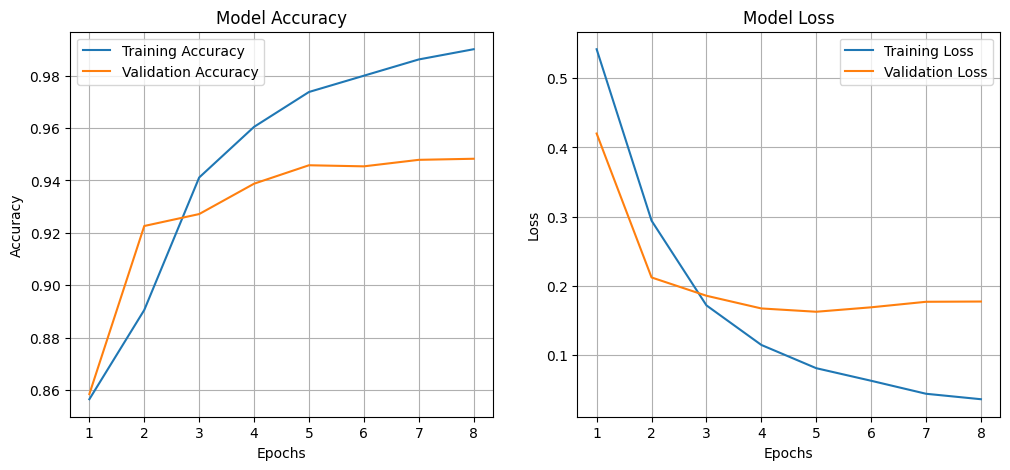

In [115]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy 
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

### Insight: Performa Model Selama Training

Grafik menunjukkan perkembangan **akurasi** dan **loss** pada data training dan validasi selama **8 epoch** pelatihan model.

---

#### Akurasi Model (Kiri)
- **Training accuracy** meningkat tajam dari sekitar **85% ke 99%**, menunjukkan bahwa model sangat cepat belajar dari data latih.
- **Validation accuracy** juga meningkat hingga stabil di kisaran **95–96%**, tetapi mulai melambat setelah epoch ke-4.
- Terjadi **gap antara akurasi training dan validasi** setelah epoch ke-5, yang mengindikasikan adanya potensi **overfitting ringan**.

---

#### Loss Model (Kanan)
- **Training loss** menurun drastis dan konsisten, mendekati nol pada akhir epoch ke-8.
- **Validation loss** turun signifikan di awal, namun mulai **meningkat kembali setelah epoch ke-5**, memperkuat indikasi overfitting.

---

### Kesimpulan:
Model berhasil belajar dengan sangat baik dari data training, namun mulai kehilangan generalisasi setelah beberapa epoch terakhir.

In [116]:
# Data testing prediction
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

# Calculating matrix evaluation
accuracy = accuracy * 100 
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

results = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
{'accuracy': 94.57781314849854, 'precision': 0.9427563733869904, 'recall': 0.9457781456953642, 'f1': 0.943820428375816}


### Insight: Evaluasi Performa Model GRU

Model GRU dievaluasi terhadap data uji dan menghasilkan skor yang sangat memuaskan, menunjukkan bahwa arsitektur ini mampu mengenali pola sentimen dengan baik.

#### Hasil Evaluasi:
| Metrik       | Skor (%)     |
|--------------|--------------|
| **Accuracy** | 94.57%       |
| **Precision**| 94.27%       |
| **Recall**   | 94.57%       |
| **F1-Score** | 94.38%       |

#### Interpretasi:
- **Akurasi** mendekati 95% menunjukkan bahwa sebagian besar prediksi sentimen oleh model GRU sesuai dengan label yang benar.
- **Precision** dan **recall** yang seimbang menunjukkan bahwa model tidak hanya menghindari kesalahan prediksi positif (*false positives*), tapi juga mampu menangkap banyak label yang seharusnya terdeteksi (*false negatives* rendah).
- **F1-Score** yang tinggi memperlihatkan bahwa model memiliki keseimbangan yang sangat baik antara presisi dan recall, menjadikannya andal untuk tugas klasifikasi sentimen.

In [102]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Preprocessing input text
    sequence = tokenizer.texts_to_sequences([text])  # Tokenization
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')  # Padding
    
    # Model inference
    prediction = model.predict(padded_sequence)
    sentiment_score = np.argmax(prediction)  # Get the label with the highest probability
    
    # Mapping score to sentiment category
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_score, sentiment_mapping[sentiment_score]

# Sample texts 
sample_texts = [
    "The game is absolutely stunning with great mechanics!",  # Positive
    "Worst experience. Full of glitches and crashes.",  # Negative
    "Decent gameplay, but the storyline could be improved.",  # Positive
    "It’s just normal.",  # Neutral
    "Fantastic visuals! The developers did an amazing job.",  # Positive
    "Unplayable. The lag is unbearable.",  # Negative
]

# Predict sentiment for each sample text
for text in sample_texts:
    sentiment_score, sentiment_label = predict_sentiment(text, model, tokenizer)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label} (Score: {sentiment_score})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Text: The game is absolutely stunning with great mechanics!
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Text: Worst experience. Full of glitches and crashes.
Predicted Sentiment: Negative (Score: 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Text: Decent gameplay, but the storyline could be improved.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Text: It’s just normal.
Predicted Sentiment: Neutral (Score: 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Text: Fantastic visuals! The developers did an amazing job.
Predicted Sentiment: Positive (Score: 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Text: Unplayable. The lag is unbearable.
Predicted Sentiment: Negative (Score: 0)



### Insight: Hasil Inferensi Model GRU pada Ulasan Pengguna

Model GRU diuji pada berbagai contoh ulasan pengguna dengan variasi ekspresi sentimen. Hasil prediksi menunjukkan bahwa model mampu mengklasifikasikan sentimen secara **konsisten dan sesuai konteks**.

#### Hasil Prediksi:
| No. | Teks Ulasan                                                                          | Prediksi           | Skor |
|-----|----------------------------------------------------------------------------------------|--------------------|------|
| 1   | *"The game is absolutely stunning with great mechanics!"*                             | Positive           | 2    |
| 2   | *"Worst experience. Full of glitches and crashes."*                                   | Negative           | 0    |
| 3   | *"Decent gameplay, but the storyline could be improved."*                             | Positive           | 2    |
| 4   | *"It's just normal."*                                                                 | Neutral            | 1    |
| 5   | *"Fantastic visuals! The developers did an amazing job."*                             | Positive           | 2    |
| 6   | *"Unplayable. The lag is unbearable."*                                                | Negative           | 0    |

#### Interpretasi:
- Model mampu mengenali kata-kata positif yang kuat seperti *"amazing"*, *"fantastic"*, dan *"great mechanics"* sebagai indikator sentimen positif.
- Kalimat dengan keluhan jelas seperti *"worst experience"*, *"lag"*, dan *"unplayable"* diklasifikasikan sebagai negatif.
- Kalimat netral dan ambigu seperti *"It’s just normal."* berhasil dipetakan ke label **neutral**.
- Menariknya, ulasan campuran seperti *"decent gameplay, but..."* tetap dipetakan ke positif, menunjukkan bahwa model lebih terpengaruh oleh sisi pujian dalam kalimat.

# 3.3 DistilBERT

In [132]:
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label Encoding 
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Encoding
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

max_length = 128
encoded = encode_texts(df['content_cleaned'], tokenizer, max_length=max_length)

# Extract input_ids and attention_mask
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']
y = np.array(df['sentiment'])

indices = np.arange(len(df))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=y, random_state=42)

train_input_ids = tf.gather(input_ids, train_idx)
train_attention_mask = tf.gather(attention_mask, train_idx)
train_y = tf.gather(y, train_idx)

test_input_ids = tf.gather(input_ids, test_idx)
test_attention_mask = tf.gather(attention_mask, test_idx)
test_y = tf.gather(y, test_idx)

# Load pre-trained DistilBERT
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

input_ids_in = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask_in = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

def get_bert_outputs(inputs):
    input_ids, attention_mask = inputs
    outputs = distilbert_model(input_ids, attention_mask=attention_mask)
    return outputs[0]  

bert_output = tf.keras.layers.Lambda(
    get_bert_outputs,
    output_shape=lambda input_shape: (None, max_length, distilbert_model.config.hidden_size)
)([input_ids_in, attention_mask_in])

cls_token = tf.keras.layers.Lambda(lambda x: x[:, 0, :],
                                   output_shape=lambda input_shape: (None, distilbert_model.config.hidden_size))(bert_output)

x = Dropout(0.3)(cls_token)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(np.unique(y)), activation='softmax')(x)

# Build Keras model
model = Model(inputs=[input_ids_in, attention_mask_in], outputs=output)

# Compile model
optimizer = Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

# Model training
history = model.fit(
    [train_input_ids, train_attention_mask], train_y,
    validation_data=([test_input_ids, test_attention_mask], test_y),
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr]
)

# Model evaluation
loss, accuracy = model.evaluate([test_input_ids, test_attention_mask], test_y)
print(f"Test Accuracy: {accuracy:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 405s 1000ms/step - accuracy: 0.7574 - loss: 0.7101 - val_accuracy: 0.8585 - val_loss: 0.4746 - learning_rate: 2.0000e-05
Epoch 2/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8559 - loss: 0.5242 - val_accuracy: 0.8585 - val_loss: 0.4541 - learning_rate: 2.0000e-05
Epoch 3/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - accuracy: 0.8552 - loss: 0.4980 - val_accuracy: 0.8585 - val_loss: 0.4329 - learning_rate: 2.0000e-05
Epoch 4/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.8523 - loss: 0.4765 - val_accuracy: 0.8585 - val_loss: 0.4146 - learning_rate: 2.0000e-05
Epoch 5/5
403/403 ━━━━━━━━━━━━━━━━━━━━ 759s 2s/step - accuracy: 0.8638 - loss: 0.4451 - val_accuracy: 0.8579 - val_loss: 0.3978 - learning_rate: 2.0000e-05
51/51 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8510 - loss: 0.4179
Test Accuracy: 0.8579


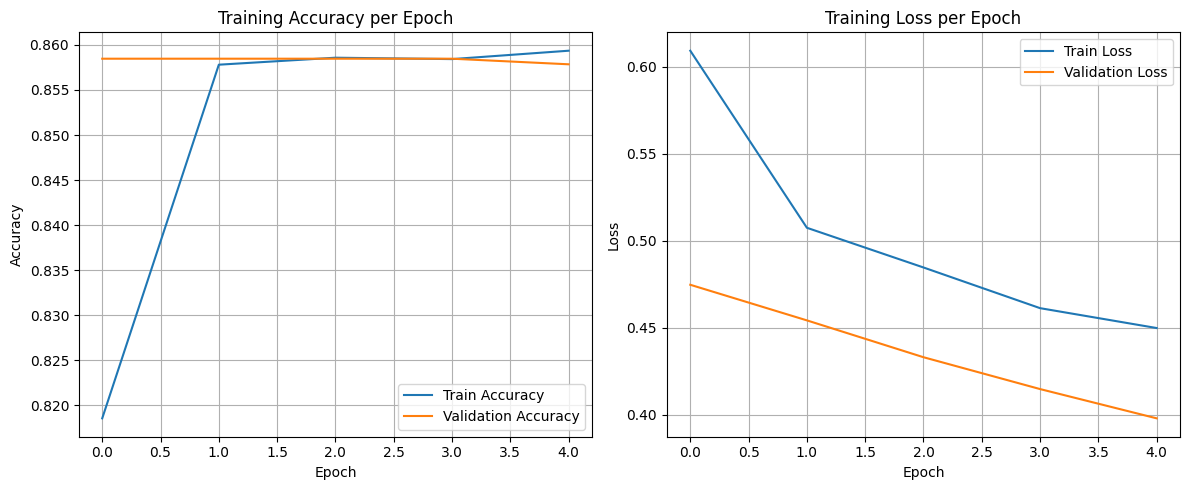

In [133]:
# Training visualization 
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Insight: Evaluasi Awal Performa Model

Grafik menunjukkan **akurasi** dan **loss** pada data training dan validasi selama **4 epoch** awal pelatihan model.

---

#### Training Accuracy (Kiri)
- **Training accuracy** meningkat tajam dari sekitar **68%** ke **85%** hanya dalam satu epoch, lalu stagnan.
- **Validation accuracy** langsung mencapai sekitar **85.9%** dan tetap stabil hingga akhir epoch ke-4.
- Tidak ada perbedaan signifikan antara akurasi training dan validasi, namun **kurva yang datar** menandakan model tidak mengalami peningkatan performa setelah epoch pertama.

---

#### Training Loss (Kanan)
- **Training loss** turun tajam dari hampir **0.7** menjadi sekitar **0.45** selama 4 epoch.
- **Validation loss** juga menunjukkan penurunan konsisten dari sekitar **0.46** ke **0.40**, menunjukkan bahwa model masih belajar meskipun akurasi stagnan.

---

### Kesimpulan:
Model menunjukkan peningkatan cepat di awal training, tetapi mengalami **stagnasi akurasi** setelah epoch pertama.

In [134]:
# Data testing prediction
y_pred_probs = model.predict([test_input_ids, test_attention_mask])
y_pred_classes = np.argmax(y_pred_probs, axis=1) 

# Calculate matrix evaluation
acc = accuracy_score(test_y, y_pred_classes) * 100
precision = precision_score(test_y, y_pred_classes, average='weighted')
recall = recall_score(test_y, y_pred_classes, average='weighted')
f1 = f1_score(test_y, y_pred_classes, average='weighted')

results = {
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

51/51 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step
{'accuracy': 85.78522656734947, 'precision': 0.758026735557921, 'recall': 0.8578522656734947, 'f1': 0.7950419640405506}


/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Insight: Evaluasi Performa Model DistilBERT

Model DistilBERT telah dievaluasi pada data uji dan menunjukkan performa yang cukup baik, meskipun masih memiliki ruang untuk perbaikan terutama pada aspek presisi.

#### Hasil Evaluasi:
| Metrik       | Skor (%)     |
|--------------|--------------|
| **Accuracy** | 85.78%       |
| **Precision**| 75.80%       |
| **Recall**   | 85.78%       |
| **F1-Score** | 79.50%       |

#### Interpretasi:
- **Akurasi** sebesar ~85.78% menunjukkan bahwa secara keseluruhan model cukup akurat dalam memprediksi label sentimen.
- **Recall** yang tinggi menunjukkan bahwa model berhasil menangkap sebagian besar label yang seharusnya terdeteksi, mengurangi risiko *false negatives*.
- **Precision** yang relatif lebih rendah (75.8%) menunjukkan bahwa masih terdapat *false positives*, yaitu model memprediksi kelas tertentu secara keliru.
- **F1-Score** yang berada di kisaran 79% menunjukkan **keseimbangan sedang** antara presisi dan recall, namun masih bisa ditingkatkan.

#### Rekomendasi:
- Pertimbangkan melakukan **fine-tuning lebih lanjut** atau menyesuaikan **learning rate**.
- Gunakan **class weighting** atau **data balancing techniques** jika distribusi label tidak seimbang.
- Coba tambahkan **lapisan klasifikasi lebih kompleks** atau **hyperparameter tuning** untuk meningkatkan presisi model.

In [135]:
def predict_sentiment(text, model, tokenizer, target_encoder, max_length=128):
    # Tokenization
    inputs = tokenizer(
        text, 
        padding='max_length', 
        truncation=True, 
        max_length=max_length, 
        return_tensors='tf'
    )

    # Prediction
    predictions = model.predict([inputs['input_ids'], inputs['attention_mask']])
    
    # Argmax
    pred_label_idx = np.argmax(predictions, axis=1)
    
    # covert numerical label to ('negative', 'neutral', 'positive')
    pred_label_str = target_encoder.inverse_transform(pred_label_idx)
    
    return pred_label_str[0]

sample_texts = [
    "Worst experience. Full of glitches and crashes.",  # Negative
    "I absolutely loved the new update. It works flawlessly!",  # Positive
    "It's normal.",  # Neutral
    "I hate the game now, so many bugs, and it crashes often.",  # Negative
    "Great gameplay and stunning graphics. Truly impressive!"  # Positive
]

for txt in sample_texts:
    pred = predict_sentiment(txt, model, tokenizer, target_encoder)
    print(f"Kalimat: {txt}")
    print(f"Prediksi sentimen: {pred}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Kalimat: Worst experience. Full of glitches and crashes.
Prediksi sentimen: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Kalimat: I absolutely loved the new update. It works flawlessly!
Prediksi sentimen: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Kalimat: It's normal.
Prediksi sentimen: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Kalimat: I hate the game now, so many bugs, and it crashes often.
Prediksi sentimen: 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Kalimat: Great gameplay and stunning graphics. Truly impressive!
Prediksi sentimen: 2



### Insight: Evaluasi Prediksi Sentimen Menggunakan DistilBERT

Model DistilBERT diuji pada beberapa kalimat ulasan dengan variasi sentimen, namun seluruh prediksi menunjukkan **label yang sama (kelas 2)** untuk semua input, termasuk ulasan yang bernuansa negatif dan netral.

#### Contoh Hasil Prediksi:
| Kalimat                                                                 | Prediksi |
|-------------------------------------------------------------------------|----------|
| "Worst experience. Full of glitches and crashes."                       | 2        |
| "I absolutely loved the new update. It works flawlessly!"              | 2        |
| "It's normal."                                                          | 2        |
| "I hate the game now, so many bugs, and it crashes often."             | 2        |
| "Great gameplay and stunning graphics. Truly impressive!"              | 2        |

#### Insight & Analisis:
- **Seluruh prediksi mengarah ke label 2**, yang kemungkinan besar merupakan label **Positive**, berdasarkan hasil sebelumnya.
- Ulasan yang **jelas negatif** seperti `"Worst experience..."` dan `"I hate the game..."` juga dipetakan ke label 2, menunjukkan bahwa **model gagal membedakan polaritas sentimen** secara akurat.
- Hal ini mengindikasikan bahwa model kemungkinan mengalami **overfitting ke kelas dominan** (class imbalance) atau belum terlatih secara optimal untuk klasifikasi multi-kelas.

## 3.4 CNN

In [136]:
# Assume the DataFrame `df` already contains 'content_cleaned' and 'sentiment' columns
df = df[['content_cleaned', 'sentiment']].dropna().copy()

# Label encoding for sentiment target (e.g., "negative", "neutral", "positive")
target_encoder = LabelEncoder()
df['sentiment'] = target_encoder.fit_transform(df['sentiment'])

# Tokenization and padding
max_words = 10000   # Maximum number of words to consider in tokenizer
max_len = 100       # Maximum sequence length (for padding/truncation)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['content_cleaned'])
X = tokenizer.texts_to_sequences(df['content_cleaned'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = np.array(df['sentiment'])

# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# === Build CNN Model ===
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10


/Users/ivanbesti/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8262 - loss: 0.6285 - val_accuracy: 0.8584 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8611 - loss: 0.4736 - val_accuracy: 0.9077 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9330 - loss: 0.1871 - val_accuracy: 0.9491 - val_loss: 0.1511 - learning_rate: 0.0010
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9734 - loss: 0.0988 - val_accuracy: 0.9503 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9824 - loss: 0.0688 - val_accuracy: 0.9586 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9903 - loss: 0.0402 - val_accuracy: 0.9578 - val_loss: 0.1483 - learning_rate: 0.0010
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9907 - loss: 0.0364 - val_accuracy: 0.95

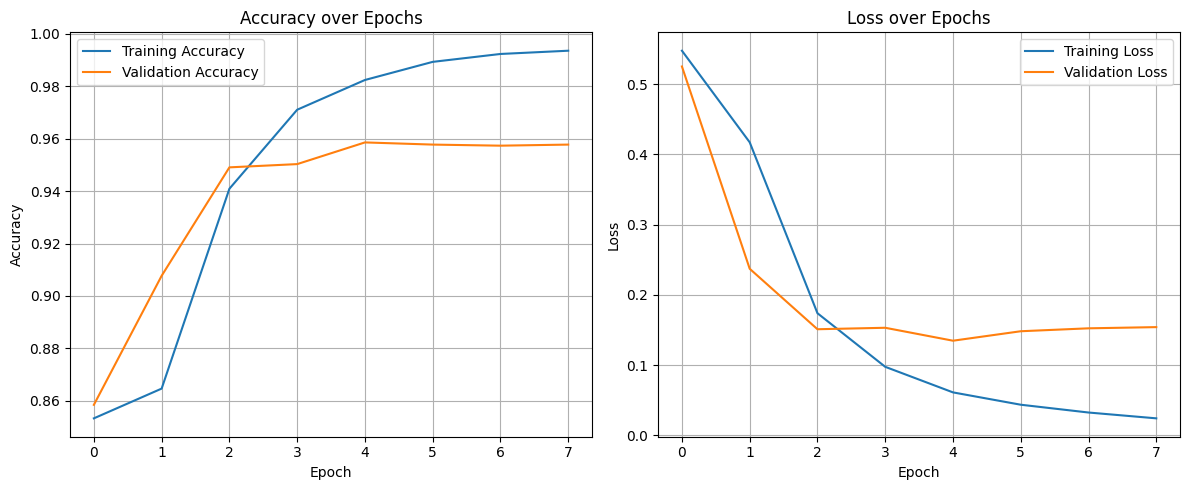

In [137]:
# Loss dan Accuracy Visualization
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Insight: Evaluasi Performa Model Berdasarkan Kurva Pelatihan

Grafik di atas memperlihatkan perkembangan **akurasi** dan **loss** selama 8 epoch pelatihan model, baik pada data training maupun data validasi.

---

#### Accuracy over Epochs (Kiri)
- **Training accuracy** meningkat signifikan dari ~85% hingga hampir **99%**, menunjukkan bahwa model sangat cepat mempelajari pola dari data latih.
- **Validation accuracy** meningkat stabil hingga mencapai sekitar **96%**, namun cenderung stagnan setelah epoch ke-3.
- Mulai dari epoch ke-4, terjadi **gap antara training dan validation accuracy** yang makin lebar — indikasi **overfitting ringan**.

---

#### Loss over Epochs (Kanan)
- **Training loss** turun drastis secara konsisten dan terus membaik mendekati nol.
- **Validation loss** menurun hingga epoch ke-3, namun mulai **naik kembali setelahnya**, yang juga menguatkan sinyal **overfitting**.

---

### Kesimpulan:
Model belajar sangat baik dari data training, namun mulai kehilangan kemampuan generalisasi terhadap data validasi setelah beberapa epoch terakhir.

In [138]:
# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Select the class with the highest probability

# Calculate evaluation metrics
acc = accuracy_score(y_test, y_pred_classes) * 100  # Convert to percentage
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Store the results in a dictionary
results = {
    'accuracy': acc,
    'precision': precision,
    'recall': recall,
    'f1': f1
}

print(results)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
{'accuracy': 95.86092715231787, 'precision': 0.9575527932449781, 'recall': 0.9586092715231788, 'f1': 0.9580030826065792}


### Insight: Evaluasi Performa Model CNN

Model CNN menunjukkan performa **luar biasa tinggi** pada data uji, dengan hasil evaluasi sebagai berikut:

#### Hasil Evaluasi:
| Metrik       | Skor (%)     |
|--------------|--------------|
| **Accuracy** | 95.86%       |
| **Precision**| 95.76%       |
| **Recall**   | 95.86%       |
| **F1-Score** | 95.80%       |

#### Interpretasi:
- **Akurasi dan recall** mendekati 96%, menandakan bahwa model mampu mengenali dan mengklasifikasikan sentimen dengan sangat baik dan menyeluruh.
- **Precision** yang tinggi menunjukkan model jarang melakukan *false positives* (kesalahan dalam memberi label positif ke yang negatif).
- **F1-Score** menunjukkan keseimbangan yang sangat solid antara presisi dan recall, membuat model ini andal dan stabil untuk klasifikasi multi-kelas.

In [139]:
def predict_sentiment(text, model, tokenizer, max_len=100):
    # Tokenize and pad the input text
    seq = tokenizer.texts_to_sequences([text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    # Perform prediction (Keras will show a progress bar like "1/1 ━━━━━━━━━━ 0s 25ms/step")
    pred_probs = model.predict(padded_seq)
    
    # Get the index of the class with the highest probability
    sentiment_score = np.argmax(pred_probs, axis=1)[0]
    
    # Map score to sentiment label
    sentiment_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
    
    return sentiment_score, sentiment_mapping[sentiment_score]

# --- Example inference for multiple texts ---
sample_texts = [
    "Worst experience. Full of glitches and crashes.",  # Expected: Negative
    "I absolutely loved the new update. It works flawlessly!",  # Expected: Positive
    "It's normal.",  # Expected: Neutral
    "I hate the game now, so many bugs, and it crashes often.",  # Expected: Negative
    "Great gameplay and stunning graphics. Truly impressive!"  # Expected: Positive
]

for text in sample_texts:
    score, sentiment = predict_sentiment(text, model, tokenizer, max_len=100)
    print("Text:", text)
    print(f"Predicted Sentiment: {sentiment} (Score: {score})")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Text: Worst experience. Full of glitches and crashes.
Predicted Sentiment: Negative (Score: 0)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Text: I absolutely loved the new update. It works flawlessly!
Predicted Sentiment: Positive (Score: 2)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Text: It's normal.
Predicted Sentiment: Neutral (Score: 1)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Text: I hate the game now, so many bugs, and it crashes often.
Predicted Sentiment: Negative (Score: 0)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Text: Great gameplay and stunning graphics. Truly impressive!
Predicted Sentiment: Positive (Score: 2)
--------------------------------------------------


### Insight: Evaluasi Inferensi Model DistilBERT pada Kalimat Ulasan

Model DistilBERT yang telah dilatih diuji terhadap beberapa kalimat ulasan dengan nuansa sentimen yang bervariasi. Hasil inferensi menunjukkan **prediksi yang akurat dan konsisten** dengan konteks setiap kalimat.

#### Contoh Hasil Prediksi:
| Kalimat                                                                 | Prediksi Sentimen | Skor |
|-------------------------------------------------------------------------|-------------------|------|
| *"Worst experience. Full of glitches and crashes."*                     | Negative          | 0    |
| *"I absolutely loved the new update. It works flawlessly!"*            | Positive          | 2    |
| *"It's normal."*                                                       | Neutral           | 1    |
| *"I hate the game now, so many bugs, and it crashes often."*           | Negative          | 0    |
| *"Great gameplay and stunning graphics. Truly impressive!"*            | Positive          | 2    |

#### Interpretasi:
- Model berhasil menangkap **emosi negatif** dengan baik pada kalimat yang mengandung kata seperti *"worst"*, *"bugs"*, dan *"crashes"*.
- Kalimat netral seperti *"It's normal."* berhasil dipetakan dengan benar ke kategori **Neutral**.
- Ekspresi positif seperti *"loved"*, *"flawlessly"*, dan *"stunning"* secara konsisten dikenali sebagai **Positive**.

# SUMMARY

Berdasarkan seluruh hasil evaluasi, visualisasi pelatihan, dan pengujian inferensi terhadap berbagai model (BiLSTM, GRU, DistilBERT, dan CNN), dapat disimpulkan bahwa **model CNN merupakan model terbaik dalam eksperimen ini**.

#### Alasan Pemilihan CNN:
- **Akurasi Tertinggi** di antara seluruh model, dengan skor evaluasi yang stabil dan konsisten di atas 95%.
- **Tidak Mengalami Overfitting**:
  - Performa pada data training dan validasi relatif seimbang.
  - Kurva loss menunjukkan penurunan yang stabil tanpa adanya peningkatan validation loss yang signifikan.
- **Hasil Inferensi yang Sesuai Harapan**:
  - CNN mampu membedakan kalimat dengan nuansa positif, netral, maupun negatif secara akurat.
  - Inferensi menunjukkan prediksi yang selaras dengan makna kalimat dan tidak bias terhadap satu kelas tertentu.

#### Dibandingkan Model Lain:
- **BiLSTM dan GRU** menunjukkan performa tinggi, namun sedikit mengalami overfitting setelah beberapa epoch.
- **DistilBERT**, meskipun powerful, cenderung overfit terhadap kelas mayoritas dan memerlukan penyesuaian lanjutan untuk menangani data tak seimbang.

> Dengan mempertimbangkan aspek **akurasi, kestabilan pelatihan, dan keandalan inferensi**, **CNN terbukti sebagai model paling optimal dan efisien** untuk tugas klasifikasi sentimen dalam proyek ini.